In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data = pd.read_csv('./data/IBOV.csv')

# Análise da Correlação dos dados

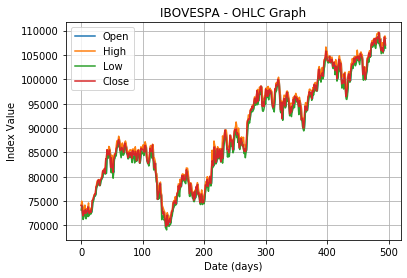

In [3]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(data['Date'])), data['Open'].values, label='Open')
ax.plot(np.arange(len(data['Date'])), data['High'].values, label='High')
ax.plot(np.arange(len(data['Date'])), data['Low'].values, label='Low')
ax.plot(np.arange(len(data['Date'])), data['Close'].values, label='Close')
ax.set(xlabel='Date (days)', ylabel='Index Value',
       title='IBOVESPA - OHLC Graph')
ax.legend()
ax.grid()

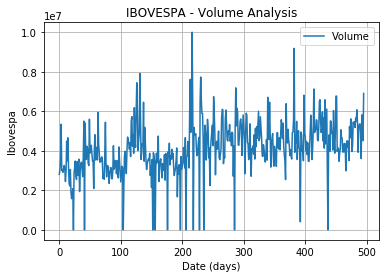

In [4]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(data['Date'])), data['Volume'].values, label='Volume')
ax.set(xlabel='Date (days)', ylabel='Ibovespa',
       title='IBOVESPA - Volume Analysis')
ax.legend()
ax.grid()

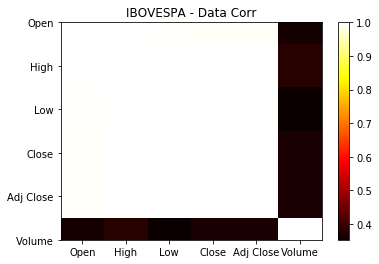

In [5]:
corr = data.corr()  
plt.imshow(corr, cmap='hot', interpolation='none')  
plt.colorbar()  
plt.xticks(range(len(corr)), corr.columns)  
plt.yticks(range(len(corr)), corr.columns)
plt.title('IBOVESPA - Data Corr')
plt.savefig("correl.png")  
plt.show()

# Processamento dos Dados (ARIMA - IBOVESPA [Close])

In [6]:
df = pd.read_csv('./data/IBOV.csv', header=0, index_col=0)
df = df['Close']
data = pd.Series(df.values,
                index = pd.DatetimeIndex(
                    data = (tuple(pd.date_range('27/11/2017',
                                                periods = 496,
                                                freq = 'B'))),
                    freq = 'B'
                ))

## Teste para validar se a função é estacionária
##### p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
##### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

### Para d= 0

Results of Dickey-Fuller Test:
Test Statistic                  -0.981747
p-value                          0.759863
Number of Lags                   2.000000
Number of Observations Used    493.000000
dtype: float64


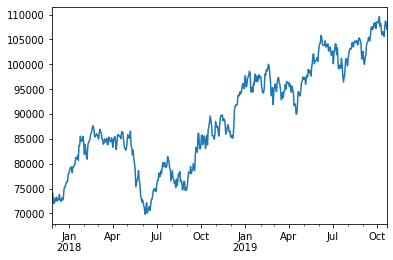

In [7]:
import pandas as pd
print("Results of Dickey-Fuller Test:")
df_test = adfuller(data, autolag = "AIC")
df_output = pd.Series(df_test[0:4],
                     index = ["Test Statistic", "p-value", "Number of Lags",
                             "Number of Observations Used"])
print(df_output)
data.plot()

### Para d= 1

Results of Dickey-Fuller Test:
Test Statistic                -1.736166e+01
p-value                        5.199467e-30
Number of Lags                 1.000000e+00
Number of Observations Used    4.930000e+02
dtype: float64


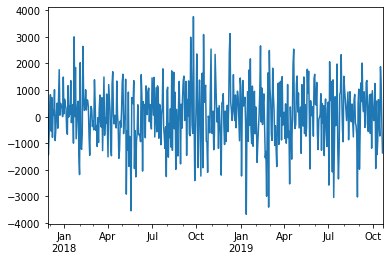

In [8]:
import pandas as pd
data_diff1 = data.diff().dropna()
print("Results of Dickey-Fuller Test:")
df_test = adfuller(data_diff1, autolag = "AIC")
df_output = pd.Series(df_test[0:4],
                     index = ["Test Statistic", "p-value", "Number of Lags",
                             "Number of Observations Used"])
print(df_output)
data_diff1.plot()

In [9]:
data_diff1.describe()

count     495.000000
mean       66.666667
std      1124.751595
min     -3675.000000
25%      -633.000000
50%        80.000000
75%       804.000000
max      3762.000000
dtype: float64

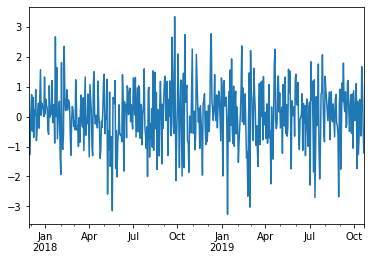

In [10]:
desv_pad_diff1 = (data_diff1/data_diff1.describe()['std'])
desv_pad_diff1.plot()

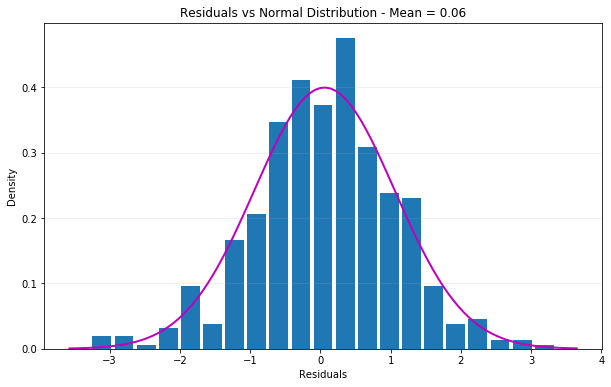

In [11]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(desv_pad_diff1, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(desv_pad_diff1)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

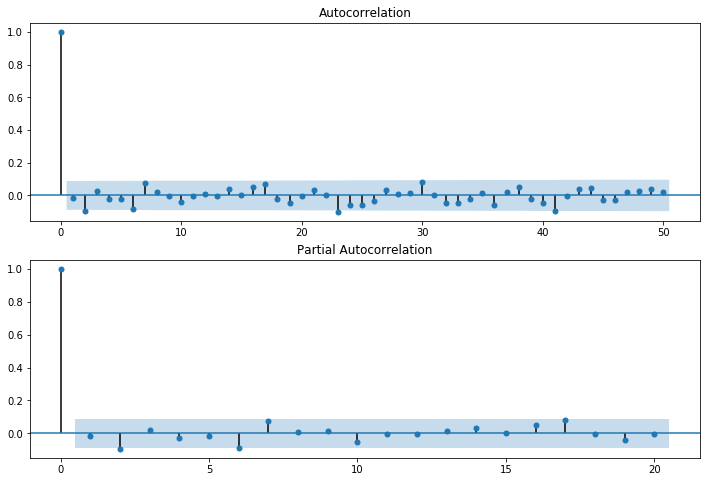

In [12]:
# Autocorrelation (MA - q)
# Partial Autocorrelation (AR - p)
#TODO: Perguntar se deve ser feito os calculos com o diff1
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data_diff1, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data_diff1, lags=20, ax=ax2)

### LOG DIFF 1

Results of Dickey-Fuller Test:
Test Statistic                -1.735318e+01
p-value                        5.256491e-30
Number of Lags                 1.000000e+00
Number of Observations Used    4.930000e+02
dtype: float64


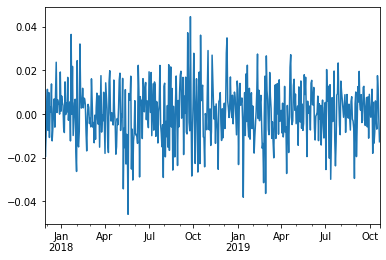

In [13]:
data_log = pd.Series(np.log(data.values),
                index = pd.DatetimeIndex(
                    data = (tuple(pd.date_range('27/11/2017',
                                                periods = 496,
                                                freq = 'B'))),
                    freq = 'B'
                ))

data_log_diff1 = data_log.diff().dropna()

print("Results of Dickey-Fuller Test:")
df_test = adfuller(data_log_diff1.values, autolag = "AIC")
df_output = pd.Series(df_test[0:4],
                     index = ["Test Statistic", "p-value", "Number of Lags",
                             "Number of Observations Used"])
print(df_output)

data_log_diff1.plot()

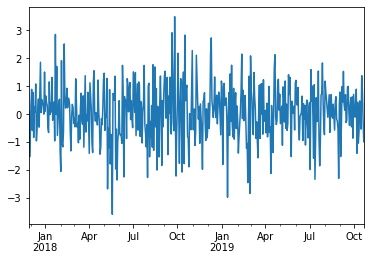

In [14]:
desv_pad = (data_log_diff1/data_log_diff1.describe()['std'])
desv_pad.plot()

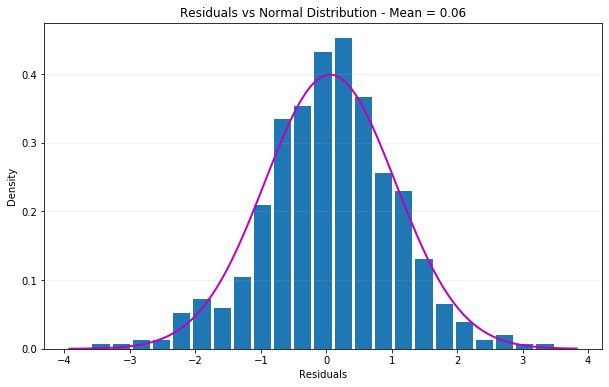

In [15]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(desv_pad, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(desv_pad)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

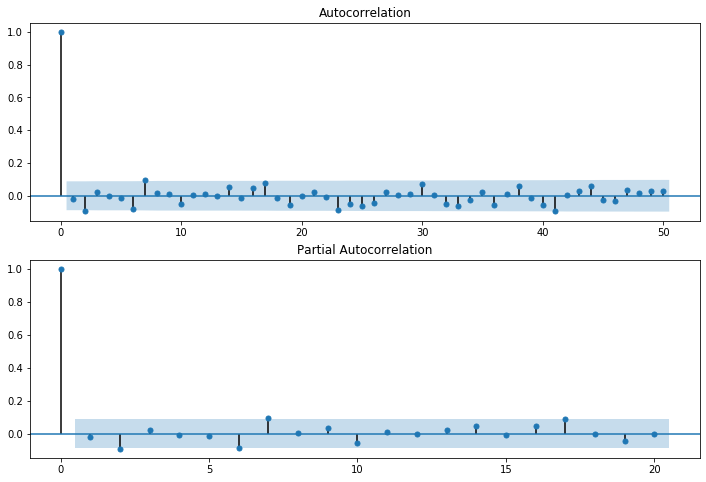

In [16]:
# Autocorrelation (MA - q)
# Partial Autocorrelation (AR - p)
#TODO: Perguntar se deve ser feito os calculos com o diff1
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data_log_diff1, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data_log_diff1, lags=20, ax=ax2)

##### Analisando o gráfico de Autocorrelation temos q=0 e p=0

### Validação do ARIMA para (0,1,0) - Método Analítico

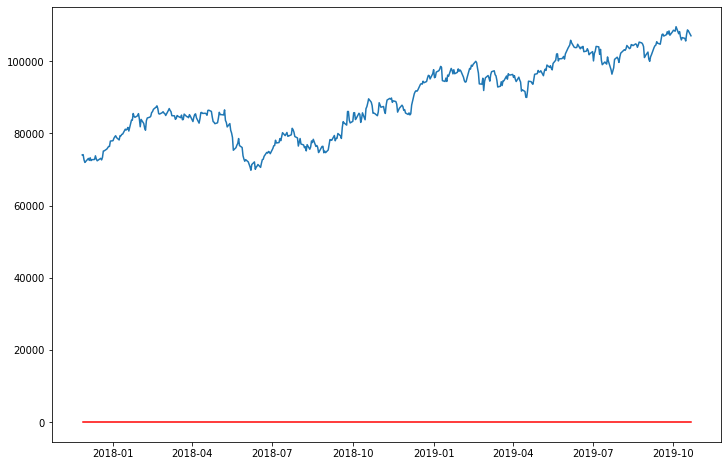

In [50]:
# ARIMA model setup
# --> Considerações do residuo do ARIMA
# --> Mean (meadia)
# --> Autocorrelation (Autocorrelação)
# --> Normal distribution (Distribuição Normal)
model = ARIMA(data, order=(0, 1, 0))
results_ar1 = model.fit()
plt.figure(figsize=(12,8))
plt.plot(data)
plt.plot(results_ar1.fittedvalues, color='red')

ARIMA [Mean]:  -1.6995608063433506e-14


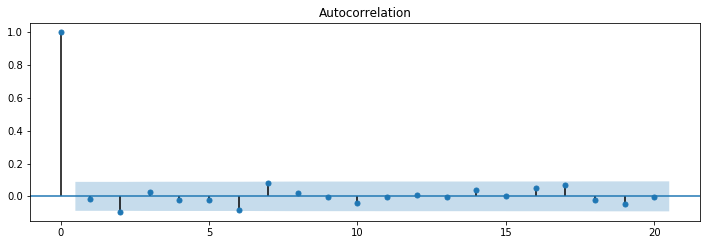

In [51]:
# Mean
print('ARIMA [Mean]: ', np.mean(results_ar1.resid))

# ACF plot to test for autorrelation
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_ar1.resid, lags=20, ax=ax1)

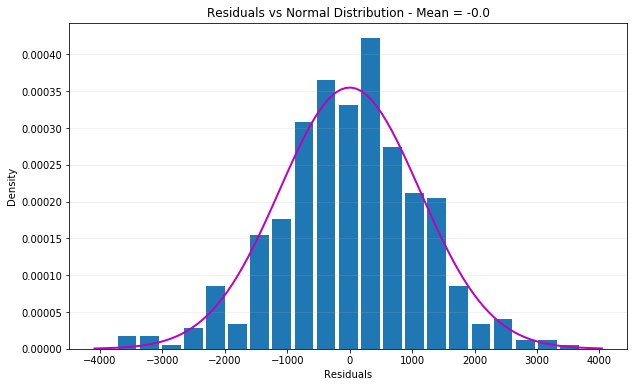

In [52]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(results_ar1.resid, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(results_ar1.resid)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

In [53]:
#Informações relevantes são:
#    AIC (Akaike): (Estudar)
#    BIC: Base info criterion (Estudar)
results_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  495
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4179.406
Method:                           css   S.D. of innovations           1123.615
Date:                Fri, 06 Dec 2019   AIC                           8362.812
Time:                        15:16:14   BIC                           8371.222
Sample:                    11-28-2017   HQIC                          8366.114
                         - 10-21-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.6667     50.503      1.320      0.187     -32.317     165.650
==============================================================================
"""

### ARIMA Iterativo - Método Computacional (Sem considerar sazonalidade)

In [83]:
arima_model = pm.auto_arima(data, error_action='ignore', suppress_warnings=True,
                    seasonal=False, start_q=0, start_p=0,
                    max_order=50, max_d=3, stepwise=False, trace=True)

Fit ARIMA: order=(0, 1, 0); AIC=8362.812, BIC=8371.222, Fit time=0.004 seconds
Fit ARIMA: order=(0, 1, 1); AIC=8364.624, BIC=8377.238, Fit time=0.023 seconds
Fit ARIMA: order=(0, 1, 2); AIC=8361.977, BIC=8378.795, Fit time=0.062 seconds
Fit ARIMA: order=(0, 1, 3); AIC=8363.672, BIC=8384.695, Fit time=0.167 seconds
Fit ARIMA: order=(0, 1, 4); AIC=8364.858, BIC=8390.085, Fit time=0.183 seconds
Fit ARIMA: order=(0, 1, 5); AIC=8366.827, BIC=8396.259, Fit time=0.357 seconds
Fit ARIMA: order=(1, 1, 0); AIC=8364.660, BIC=8377.273, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0); AIC=8362.205, BIC=8379.023, Fit time=0.098 seconds
Fit ARIMA: order=(2, 1, 1); AIC=8

In [84]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  495
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -4170.484
Method:                       css-mle   S.D. of innovations           1102.921
Date:                Fri, 06 Dec 2019   AIC                           8360.969
Time:                        15:28:34   BIC                           8403.014
Sample:                             1   HQIC                          8377.474
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.1142     42.677      1.573      0.116     -16.532     150.760
ar.L1.D.y      0.1911      0.250      0.763      0.446      -0.300       0.682
ar.L2.D.y     -0.3800      0.186     -2.043      0.042      -0.745      -0.015
ar.L3.D.y     -0.2273      0.206     -1.104      0.270      -0.631       0.176
ar.L4.D.y      0.5132      0.213      2.407      0.016       0.095       0.931
ma.L1.D.y     -0.2152      0.235     -0.914      0.361      -0.677       0.246
ma.L2.D.y      0.2943      0.169      1.745      0.082      -0.036       0.625
ma.L3.D.y      0.3067      0.183      1.680      0.094      -0.051       0.665
ma.L4.D.y     -0.6093      0.203     -2.994      0.003      -1.008      -0.211
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2830           -0.0000j            1.2830           -0.5000
AR.2            0.1450           -1.0181j            1.0284           -0.2275
AR.3            0.1450           +1.0181j            1.0284            0.2275
AR.4            1.4361           -0.0000j            1.4361           -0.0000
MA.1           -1.1750           -0.0000j            1.1750           -0.5000
MA.2            0.1674           -1.0057j            1.0195           -0.2238
MA.3            0.1674           +1.0057j            1.0195            0.2238
MA.4            1.3437           -0.0000j            1.3437           -0.0000
-----------------------------------------------------------------------------
"""

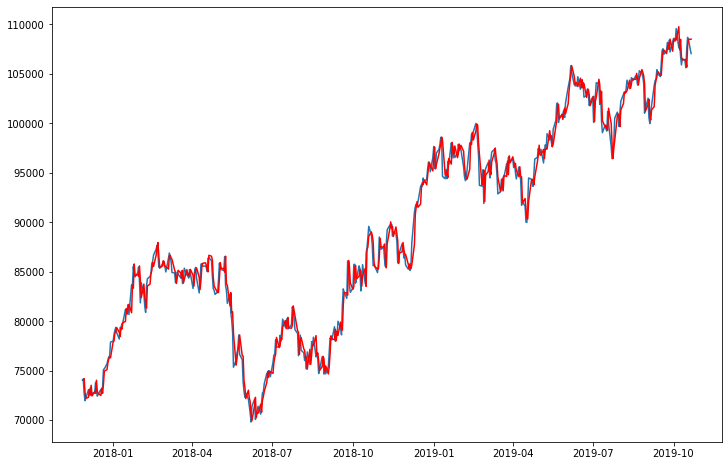

In [18]:
# ARIMA model setup
# --> Considerações do residuo do ARIMA
# --> Mean (meadia)
# --> Autocorrelation (Autocorrelação)
# --> Normal distribution (Distribuição Normal)
model = ARIMA(data, order=(4, 1, 4))
results_ar1 = model.fit()
plt.figure(figsize=(12,8))
plt.plot(data)
# plt.plot(results_ar1.fittedvalues, color='red')
plt.plot(results_ar1.predict(typ='levels'), color='red')

ARIMA [Mean]:  -0.24113477603374958


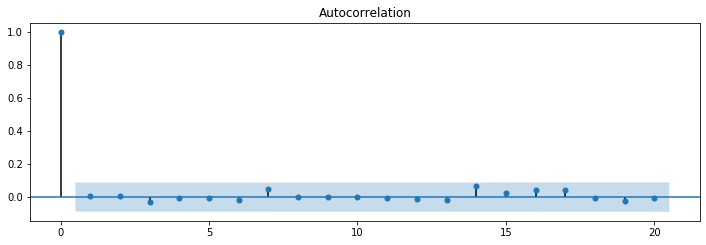

In [19]:
# Mean
print('ARIMA [Mean]: ', np.mean(results_ar1.resid))

# ACF plot to test for autorrelation
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_ar1.resid, lags=20, ax=ax1)

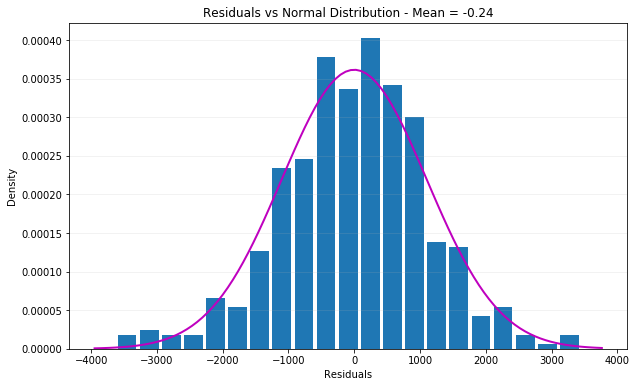

In [20]:
import matplotlib.pyplot as plt
from numpy import linspace
from scipy.stats import norm

plt.figure(figsize=(10,6))
plt.hist(results_ar1.resid, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(results_ar1.resid)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

In [21]:
forecast = results_ar1.predict(typ='levels')
actual = data[1:]

mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
me = np.mean(forecast - actual)                           # ME
mae = np.mean(np.abs(forecast - actual))                  # MAE
mpe = np.mean((forecast - actual)/actual)                 # MPE
rmse = np.mean((forecast - actual)**2)**.5                # RMSE
print('mape: %s' % mape)
print('me: %s' % me)
print('mae: %s' % mae)
print('mpe: %s' % mpe)
print('rmse: %s' % rmse)

mape: 0.009734822165845963
me: 0.2411347760333541
mae: 858.9918713518446
mpe: 0.00010688570412045886
rmse: 1103.2929953737573


In [41]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
forecasting = 2
new_data = data
train = new_data[:len(data)-forecasting]
test = new_data[-forecasting:]

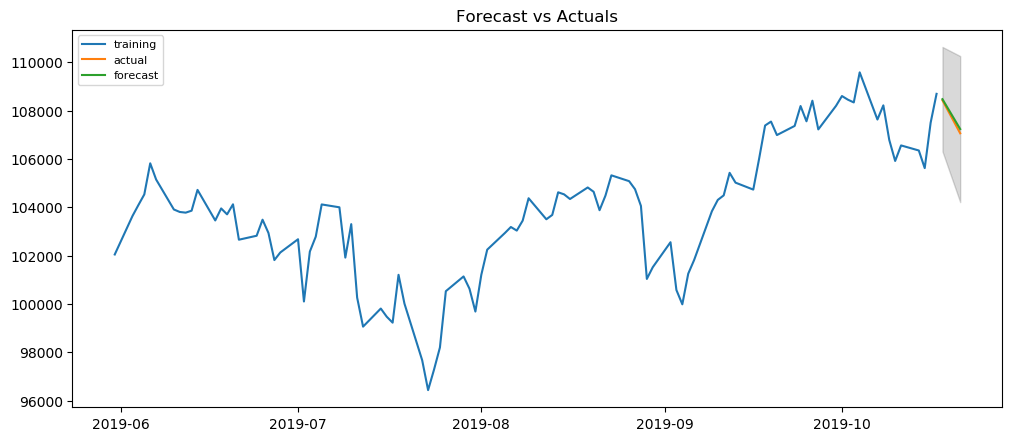

In [42]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(4, 1, 4))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(forecasting, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-100:], label='training')
plt.plot(test[-100:], label='actual')
plt.plot(fc_series[-100:], label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
## Treinamento do Residuo utilizando SVM

In [43]:
data_resid = results_ar1.resid
df_all_2 = pd.DataFrame({
    'data-29': data.shift(-2).dropna().values[:-4],
    'data-30': data.shift(-3).dropna().values[:-3],
    'data-1': data.shift(-4).dropna().values[:-2],
    'data-4': data.shift(-5).dropna().values[:-1],
    'data_diff-29': data.diff().shift(-2).dropna().values[:-4],
    'data_diff-30': data.diff().shift(-3).dropna().values[:-3],
    'data_diff-1': data.diff().shift(-4).dropna().values[:-2],
    'data_diff-4': data.diff().shift(-5).dropna().values[:-1],
    'res-29': results_ar1.resid.shift(-1).dropna().values[:-4],
    'res-30': results_ar1.resid.shift(-2).dropna().values[:-3],
    'res-1': results_ar1.resid.shift(-3).dropna().values[:-2],
    'res-4': results_ar1.resid.shift(-4).dropna().values[:-1],
    'res_diff-29': results_ar1.resid.diff().shift(-1).dropna().values[:-4],
    'res_diff-30': results_ar1.resid.diff().shift(-2).dropna().values[:-3],
    'res_diff-1': results_ar1.resid.diff().shift(-3).dropna().values[:-2],
    'res_diff-4': results_ar1.resid.diff().shift(-4).dropna().values[:-1],
    'target': results_ar1.resid.shift(-5).dropna().values
})

In [117]:
data_resid = results_ar1.resid
df_all_3 = pd.DataFrame({
    'data_diff-4': data.diff().shift(-2).dropna().values[:-4],
    'data_diff-3': data.diff().shift(-3).dropna().values[:-3],
    'data_diff-2': data.diff().shift(-4).dropna().values[:-2],
    'data_diff-1': data.diff().shift(-5).dropna().values[:-1],
    'arima_fitted': results_ar1.fittedvalues.shift(-5).values[:-5],
    'target': results_ar1.resid.shift(-5).dropna().values
})

In [118]:
df = df_all_3

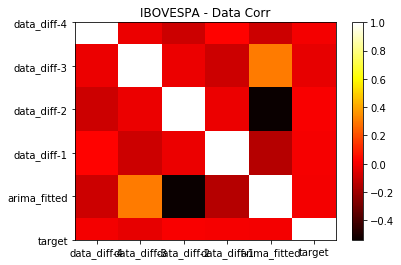

In [119]:
corr = df.corr()  
plt.imshow(corr, cmap='hot', interpolation='none')  
plt.colorbar()  
plt.xticks(range(len(corr)), corr.columns)  
plt.yticks(range(len(corr)), corr.columns)
plt.title('IBOVESPA - Data Corr')
plt.savefig("correl.png")  
plt.show()

Epoch 1/1500
343/343 [==============================] - 0s 353us/step - loss: 1256117.3007
Epoch 2/1500
343/343 [==============================] - 0s 35us/step - loss: 1253815.6494
Epoch 3/1500
343/343 [==============================] - 0s 29us/step - loss: 1252486.3440
Epoch 4/1500
343/343 [==============================] - 0s 44us/step - loss: 1251136.0521
Epoch 5/1500
343/343 [==============================] - 0s 29us/step - loss: 1249675.9206
Epoch 6/1500
343/343 [==============================] - 0s 47us/step - loss: 1248679.4353
Epoch 7/1500
343/343 [==============================] - 0s 50us/step - loss: 1247523.6713
Epoch 8/1500
343/343 [==============================] - 0s 29us/step - loss: 1246611.6979
Epoch 9/1500
343/343 [==============================] - 0s 52us/step - loss: 1245694.8404
Epoch 10/1500
343/343 [==============================] - 0s 26us/step - loss: 1244794.9687
Epoch 11/1500
343/343 [==============================] - 0s 47us/step - loss: 1244331.4628
Epoch 1

343/343 [==============================] - 0s 44us/step - loss: 1192370.4486
Epoch 92/1500
343/343 [==============================] - 0s 38us/step - loss: 1191702.8375
Epoch 93/1500
343/343 [==============================] - 0s 29us/step - loss: 1190570.7336
Epoch 94/1500
343/343 [==============================] - 0s 35us/step - loss: 1189878.1880
Epoch 95/1500
343/343 [==============================] - 0s 35us/step - loss: 1189853.6716
Epoch 96/1500
343/343 [==============================] - 0s 32us/step - loss: 1189336.2923
Epoch 97/1500
343/343 [==============================] - 0s 38us/step - loss: 1188873.8373
Epoch 98/1500
343/343 [==============================] - ETA: 0s - loss: 1192342.250 - 0s 41us/step - loss: 1188089.1299
Epoch 99/1500
343/343 [==============================] - 0s 44us/step - loss: 1186810.4818
Epoch 100/1500
343/343 [==============================] - 0s 38us/step - loss: 1186029.4971
Epoch 101/1500
343/343 [==============================] - 0s 44us/step - 

343/343 [==============================] - 0s 35us/step - loss: 1126608.2382
Epoch 180/1500
343/343 [==============================] - 0s 29us/step - loss: 1126118.5138
Epoch 181/1500
343/343 [==============================] - 0s 29us/step - loss: 1125445.6520
Epoch 182/1500
343/343 [==============================] - 0s 52us/step - loss: 1124155.4404
Epoch 183/1500
343/343 [==============================] - 0s 44us/step - loss: 1123159.6091
Epoch 184/1500
343/343 [==============================] - 0s 29us/step - loss: 1122268.1042
Epoch 185/1500
343/343 [==============================] - 0s 41us/step - loss: 1121828.0157
Epoch 186/1500
343/343 [==============================] - 0s 35us/step - loss: 1120805.2362
Epoch 187/1500
343/343 [==============================] - 0s 32us/step - loss: 1120808.7252
Epoch 188/1500
343/343 [==============================] - 0s 32us/step - loss: 1119484.0605
Epoch 189/1500
343/343 [==============================] - 0s 38us/step - loss: 1118695.3630
Epo

343/343 [==============================] - 0s 35us/step - loss: 1055279.8298
Epoch 268/1500
343/343 [==============================] - 0s 41us/step - loss: 1055072.9852
Epoch 269/1500
343/343 [==============================] - 0s 35us/step - loss: 1056133.3519
Epoch 270/1500
343/343 [==============================] - 0s 47us/step - loss: 1054809.5702
Epoch 271/1500
343/343 [==============================] - 0s 35us/step - loss: 1053756.7329
Epoch 272/1500
343/343 [==============================] - 0s 29us/step - loss: 1052849.0948
Epoch 273/1500
343/343 [==============================] - 0s 53us/step - loss: 1050879.0962
Epoch 274/1500
343/343 [==============================] - 0s 38us/step - loss: 1050932.7629
Epoch 275/1500
343/343 [==============================] - 0s 44us/step - loss: 1050179.1744
Epoch 276/1500
343/343 [==============================] - 0s 47us/step - loss: 1048861.7358
Epoch 277/1500
343/343 [==============================] - 0s 58us/step - loss: 1049118.2347
Epo

343/343 [==============================] - 0s 32us/step - loss: 1000206.3548
Epoch 356/1500
343/343 [==============================] - 0s 41us/step - loss: 999764.2633
Epoch 357/1500
343/343 [==============================] - 0s 35us/step - loss: 998991.5756
Epoch 358/1500
343/343 [==============================] - 0s 41us/step - loss: 998659.9426
Epoch 359/1500
343/343 [==============================] - 0s 41us/step - loss: 998080.1009
Epoch 360/1500
343/343 [==============================] - 0s 55us/step - loss: 998397.1246
Epoch 361/1500
343/343 [==============================] - 0s 38us/step - loss: 998437.9960
Epoch 362/1500
343/343 [==============================] - 0s 35us/step - loss: 997233.2529
Epoch 363/1500
343/343 [==============================] - 0s 41us/step - loss: 997417.0798
Epoch 364/1500
343/343 [==============================] - 0s 35us/step - loss: 996453.8426
Epoch 365/1500
343/343 [==============================] - 0s 50us/step - loss: 995968.9663
Epoch 366/150

343/343 [==============================] - 0s 41us/step - loss: 963427.6452
Epoch 445/1500
343/343 [==============================] - 0s 41us/step - loss: 962390.9093
Epoch 446/1500
343/343 [==============================] - 0s 44us/step - loss: 961241.2586
Epoch 447/1500
343/343 [==============================] - 0s 35us/step - loss: 961139.6516
Epoch 448/1500
343/343 [==============================] - 0s 32us/step - loss: 960635.8451
Epoch 449/1500
343/343 [==============================] - 0s 41us/step - loss: 960738.0805
Epoch 450/1500
343/343 [==============================] - 0s 35us/step - loss: 959852.5612
Epoch 451/1500
343/343 [==============================] - 0s 58us/step - loss: 959230.8413
Epoch 452/1500
343/343 [==============================] - 0s 52us/step - loss: 959508.5960
Epoch 453/1500
343/343 [==============================] - 0s 52us/step - loss: 959608.2728
Epoch 454/1500
343/343 [==============================] - 0s 44us/step - loss: 958457.9829
Epoch 455/1500

343/343 [==============================] - 0s 41us/step - loss: 935445.0392
Epoch 535/1500
343/343 [==============================] - 0s 38us/step - loss: 935560.7722
Epoch 536/1500
343/343 [==============================] - 0s 32us/step - loss: 935767.5907
Epoch 537/1500
343/343 [==============================] - 0s 38us/step - loss: 935160.5052
Epoch 538/1500
343/343 [==============================] - 0s 50us/step - loss: 934890.2874
Epoch 539/1500
343/343 [==============================] - 0s 32us/step - loss: 935444.7059
Epoch 540/1500
343/343 [==============================] - 0s 44us/step - loss: 935230.5191
Epoch 541/1500
343/343 [==============================] - 0s 44us/step - loss: 934981.3355
Epoch 542/1500
343/343 [==============================] - 0s 50us/step - loss: 934882.9156
Epoch 543/1500
343/343 [==============================] - 0s 32us/step - loss: 934103.6044
Epoch 544/1500
343/343 [==============================] - 0s 47us/step - loss: 935091.2914
Epoch 545/1500

343/343 [==============================] - 0s 47us/step - loss: 919183.1060
Epoch 624/1500
343/343 [==============================] - 0s 44us/step - loss: 918922.8874
Epoch 625/1500
343/343 [==============================] - 0s 38us/step - loss: 918788.5401
Epoch 626/1500
343/343 [==============================] - 0s 38us/step - loss: 918571.9114
Epoch 627/1500
343/343 [==============================] - 0s 47us/step - loss: 917199.3052
Epoch 628/1500
343/343 [==============================] - 0s 47us/step - loss: 917464.2649
Epoch 629/1500
343/343 [==============================] - 0s 41us/step - loss: 917074.3786
Epoch 630/1500
343/343 [==============================] - 0s 41us/step - loss: 917333.7684
Epoch 631/1500
343/343 [==============================] - 0s 52us/step - loss: 917700.9524
Epoch 632/1500
343/343 [==============================] - 0s 41us/step - loss: 916715.8675
Epoch 633/1500
343/343 [==============================] - 0s 47us/step - loss: 917032.4226
Epoch 634/1500

343/343 [==============================] - 0s 35us/step - loss: 900958.0932
Epoch 713/1500
343/343 [==============================] - 0s 41us/step - loss: 900093.1977
Epoch 714/1500
343/343 [==============================] - 0s 35us/step - loss: 899918.9027
Epoch 715/1500
343/343 [==============================] - 0s 35us/step - loss: 899968.2117
Epoch 716/1500
343/343 [==============================] - 0s 50us/step - loss: 899319.5913
Epoch 717/1500
343/343 [==============================] - 0s 47us/step - loss: 899286.3949
Epoch 718/1500
343/343 [==============================] - 0s 44us/step - loss: 899892.5348
Epoch 719/1500
343/343 [==============================] - 0s 41us/step - loss: 899718.6972
Epoch 720/1500
343/343 [==============================] - 0s 35us/step - loss: 899398.2883
Epoch 721/1500
343/343 [==============================] - 0s 47us/step - loss: 899887.8251
Epoch 722/1500
343/343 [==============================] - 0s 38us/step - loss: 900375.3050
Epoch 723/1500

343/343 [==============================] - 0s 29us/step - loss: 888205.2722
Epoch 803/1500
343/343 [==============================] - 0s 38us/step - loss: 888387.8202
Epoch 804/1500
343/343 [==============================] - 0s 29us/step - loss: 888292.9085
Epoch 805/1500
343/343 [==============================] - 0s 38us/step - loss: 889129.5672
Epoch 806/1500
343/343 [==============================] - 0s 32us/step - loss: 890525.1450
Epoch 807/1500
343/343 [==============================] - 0s 41us/step - loss: 889821.5523
Epoch 808/1500
343/343 [==============================] - 0s 50us/step - loss: 888180.0789
Epoch 809/1500
343/343 [==============================] - 0s 41us/step - loss: 887509.1173
Epoch 810/1500
343/343 [==============================] - 0s 47us/step - loss: 887834.0831
Epoch 811/1500
343/343 [==============================] - 0s 38us/step - loss: 886641.7163
Epoch 812/1500
343/343 [==============================] - 0s 35us/step - loss: 888031.9216
Epoch 813/1500

343/343 [==============================] - 0s 17us/step - loss: 871662.7179
Epoch 892/1500
343/343 [==============================] - 0s 23us/step - loss: 871186.3181
Epoch 893/1500
343/343 [==============================] - 0s 20us/step - loss: 871140.5324
Epoch 894/1500
343/343 [==============================] - 0s 20us/step - loss: 870956.9510
Epoch 895/1500
343/343 [==============================] - 0s 20us/step - loss: 871062.1268
Epoch 896/1500
343/343 [==============================] - 0s 20us/step - loss: 871606.2464
Epoch 897/1500
343/343 [==============================] - 0s 23us/step - loss: 872032.3870
Epoch 898/1500
343/343 [==============================] - 0s 20us/step - loss: 871043.6993
Epoch 899/1500
343/343 [==============================] - 0s 20us/step - loss: 870242.0969
Epoch 900/1500
343/343 [==============================] - 0s 20us/step - loss: 870697.8821
Epoch 901/1500
343/343 [==============================] - 0s 20us/step - loss: 871639.2954
Epoch 902/1500

343/343 [==============================] - 0s 44us/step - loss: 858557.6399
Epoch 981/1500
343/343 [==============================] - 0s 32us/step - loss: 857981.8648
Epoch 982/1500
343/343 [==============================] - 0s 35us/step - loss: 858170.4942
Epoch 983/1500
343/343 [==============================] - 0s 38us/step - loss: 857158.1053
Epoch 984/1500
343/343 [==============================] - 0s 35us/step - loss: 857741.4162
Epoch 985/1500
343/343 [==============================] - 0s 35us/step - loss: 857408.5618
Epoch 986/1500
343/343 [==============================] - 0s 41us/step - loss: 856644.8050
Epoch 987/1500
343/343 [==============================] - 0s 32us/step - loss: 856679.6102
Epoch 988/1500
343/343 [==============================] - 0s 32us/step - loss: 855790.0268
Epoch 989/1500
343/343 [==============================] - ETA: 0s - loss: 897934.18 - 0s 41us/step - loss: 856493.4563
Epoch 990/1500
343/343 [==============================] - 0s 35us/step - loss

343/343 [==============================] - 0s 35us/step - loss: 844023.9326
Epoch 1069/1500
343/343 [==============================] - 0s 29us/step - loss: 843874.3591
Epoch 1070/1500
343/343 [==============================] - 0s 44us/step - loss: 844293.6135
Epoch 1071/1500
343/343 [==============================] - 0s 32us/step - loss: 843401.1906
Epoch 1072/1500
343/343 [==============================] - 0s 35us/step - loss: 842266.4666
Epoch 1073/1500
343/343 [==============================] - 0s 41us/step - loss: 843386.7473
Epoch 1074/1500
343/343 [==============================] - 0s 44us/step - loss: 844433.9758
Epoch 1075/1500
343/343 [==============================] - 0s 44us/step - loss: 843526.5931
Epoch 1076/1500
343/343 [==============================] - 0s 35us/step - loss: 842698.5100
Epoch 1077/1500
343/343 [==============================] - 0s 38us/step - loss: 843297.7597
Epoch 1078/1500
343/343 [==============================] - 0s 38us/step - loss: 843142.8478
Epoc

343/343 [==============================] - 0s 41us/step - loss: 833458.5845
Epoch 1157/1500
343/343 [==============================] - 0s 32us/step - loss: 833035.9366
Epoch 1158/1500
343/343 [==============================] - 0s 44us/step - loss: 832616.0011
Epoch 1159/1500
343/343 [==============================] - 0s 29us/step - loss: 832757.5346
Epoch 1160/1500
343/343 [==============================] - 0s 38us/step - loss: 834081.0736
Epoch 1161/1500
343/343 [==============================] - 0s 44us/step - loss: 833279.5257
Epoch 1162/1500
343/343 [==============================] - 0s 41us/step - loss: 833567.6039
Epoch 1163/1500
343/343 [==============================] - 0s 49us/step - loss: 832576.0372
Epoch 1164/1500
343/343 [==============================] - ETA: 0s - loss: 1082710.125 - 0s 38us/step - loss: 833740.9816
Epoch 1165/1500
343/343 [==============================] - 0s 38us/step - loss: 833011.5253
Epoch 1166/1500
343/343 [==============================] - 0s 32us

343/343 [==============================] - 0s 29us/step - loss: 823673.6183
Epoch 1245/1500
343/343 [==============================] - 0s 38us/step - loss: 824569.4566
Epoch 1246/1500
343/343 [==============================] - 0s 41us/step - loss: 823689.3315
Epoch 1247/1500
343/343 [==============================] - 0s 32us/step - loss: 824236.2708
Epoch 1248/1500
343/343 [==============================] - 0s 41us/step - loss: 825486.8417
Epoch 1249/1500
343/343 [==============================] - 0s 32us/step - loss: 825072.4357
Epoch 1250/1500
343/343 [==============================] - 0s 32us/step - loss: 823398.1128
Epoch 1251/1500
343/343 [==============================] - 0s 35us/step - loss: 822622.0833
Epoch 1252/1500
343/343 [==============================] - 0s 41us/step - loss: 823551.2671
Epoch 1253/1500
343/343 [==============================] - 0s 41us/step - loss: 823203.0087
Epoch 1254/1500
343/343 [==============================] - 0s 41us/step - loss: 822569.5044
Epoc

343/343 [==============================] - 0s 38us/step - loss: 816916.3480
Epoch 1333/1500
343/343 [==============================] - 0s 29us/step - loss: 816141.8721
Epoch 1334/1500
343/343 [==============================] - 0s 35us/step - loss: 816255.1239
Epoch 1335/1500
343/343 [==============================] - 0s 29us/step - loss: 816266.3753
Epoch 1336/1500
343/343 [==============================] - 0s 29us/step - loss: 816382.7651
Epoch 1337/1500
343/343 [==============================] - 0s 35us/step - loss: 816714.7823
Epoch 1338/1500
343/343 [==============================] - 0s 35us/step - loss: 816775.9736
Epoch 1339/1500
343/343 [==============================] - 0s 32us/step - loss: 816828.7792
Epoch 1340/1500
343/343 [==============================] - 0s 35us/step - loss: 817186.5435
Epoch 1341/1500
343/343 [==============================] - 0s 35us/step - loss: 816381.4470
Epoch 1342/1500
343/343 [==============================] - 0s 38us/step - loss: 815576.9495
Epoc

343/343 [==============================] - 0s 32us/step - loss: 808724.2919
Epoch 1422/1500
343/343 [==============================] - 0s 41us/step - loss: 809663.3478
Epoch 1423/1500
343/343 [==============================] - 0s 35us/step - loss: 809621.5204
Epoch 1424/1500
343/343 [==============================] - 0s 41us/step - loss: 809647.1565
Epoch 1425/1500
343/343 [==============================] - 0s 32us/step - loss: 808864.7717
Epoch 1426/1500
343/343 [==============================] - 0s 29us/step - loss: 809274.1975
Epoch 1427/1500
343/343 [==============================] - 0s 44us/step - loss: 808727.2505
Epoch 1428/1500
343/343 [==============================] - 0s 50us/step - loss: 809490.7236
Epoch 1429/1500
343/343 [==============================] - 0s 47us/step - loss: 810987.5621
Epoch 1430/1500
343/343 [==============================] - 0s 38us/step - loss: 808796.1135
Epoch 1431/1500
343/343 [==============================] - 0s 41us/step - loss: 809944.5654
Epoc

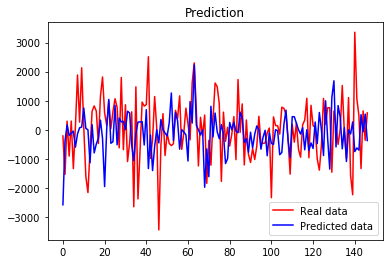

In [120]:
# Importing the dataset
X = df.drop(columns=['target']).values
y = df.target.values

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

# Initialising the ANN
model = Sequential()
model.add(Dense(12, input_dim=5, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, batch_size = 80, epochs = 1500)

y_pred = model.predict(X_test)

plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

dict_keys(['loss'])


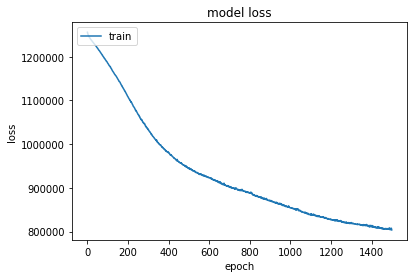

In [121]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

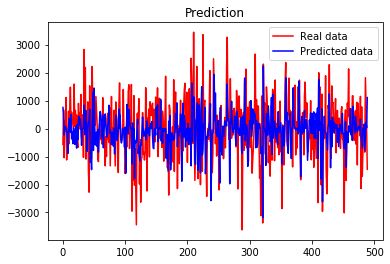

In [123]:
y_pred = model.predict(X)
plt.plot(y, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

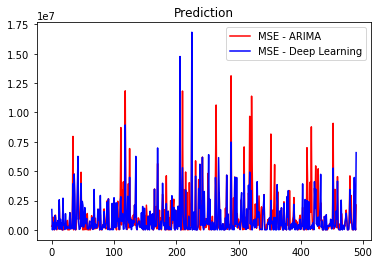

In [124]:
mse_arima = y**2
mse_deep = (y - np.hstack(y_pred))**2
plt.plot(mse_arima, color = 'red', label = 'MSE - ARIMA')
plt.plot(mse_deep, color = 'blue', label = 'MSE - Deep Learning')
plt.title('Prediction')
plt.legend()
plt.show()

In [125]:
df_error = pd.DataFrame.from_dict({
    'arima': mse_arima,
    'dp': mse_deep
})
df_error.describe()

,arima,dp
count,4.900000e+02,4.900000e+02
mean,1.222407e+06,1.036059e+06
std,1.966396e+06,1.698346e+06
min,5.181610e+00,1.890438e+00
25%,1.213062e+05,7.336747e+04
50%,4.789919e+05,3.941965e+05
75%,1.347107e+06,1.207820e+06
max,1.312116e+07,1.683255e+07


In [126]:
df_error = pd.DataFrame.from_dict({
    'arima': y,
    'dp': error_deep
})
df_error.describe()

,arima,dp
count,490.000000,490.000000
mean,2.853275,1.692464
std,1106.751568,1030.093221
min,-3622.314104,-3625.108289
25%,-681.068504,-639.958355
50%,59.726819,-12.165514
75%,704.933528,647.141045
max,3439.303853,3545.267699


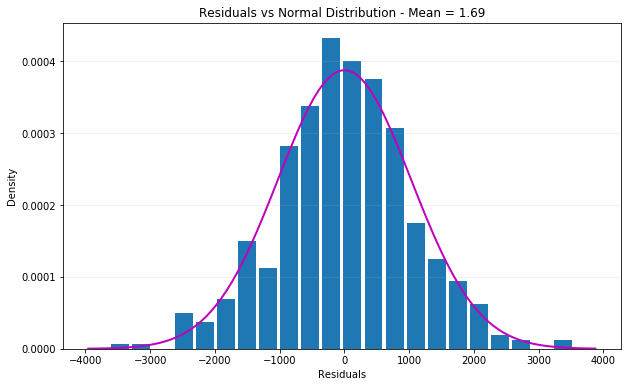

In [127]:
plt.figure(figsize=(10,6))
plt.hist(error_deep, bins='auto', density=True, rwidth=0.85, label='residuals')
mean_resid, std_resid = norm.fit(error_deep)
xmin, xmax = plt.xlim()
curve_length = linspace(xmin, xmax, 100)
bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
plt.plot(curve_length, bell_curve, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals vs Normal Distribution - Mean = '+str(round(mean_resid, 2)))
plt.show()

In [113]:
# serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

Saved model to disk
